# 1. Data Preprocessing

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# ADF Test / Canova-Hansen test to estimate our seasonal differencing term and Autocorrelation
from pmdarima.arima.utils import nsdiffs
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Seasonality
from statsmodels.tsa.seasonal import seasonal_decompose

#%matplotlib inline

(1) Summary of all columns
(2) Checking for NA
(3) Checking if seasonal decomposition has to be taken into account 
(4) Checking if data is stationary 
(5) Checking for autocorrelation and partial autocorrelation

## Importing Data & Renaming

In [2]:
data = pd.read_csv("Metro_median_sale_price_uc_sfrcondo_month.csv")
# Metro_median_sale_price_uc_sfrcondo_month
# Metro_median_sale_price_uc_sfrcondo_week

In [3]:
cities = data[data["RegionName"].isin(["Minneapolis-St Paul, MN", "Miami-Fort Lauderdale, FL", "Las Vegas, NV"])]
cities = cities.iloc[: ,5:]
cities = cities.transpose()

In [4]:
#cities.reset_index(level=0, inplace=True)
cities = cities.rename(columns={"index":"Date", 8:"MIA", 16:"MSP", 31:"LAS"})
cities.reset_index(level=0, inplace=True)
cities = cities.rename(columns={"index":"Date"})
cities

,Date,MIA,MSP,LAS
0,2008-02-29,267850.0,218239.0,268000.0
1,2008-03-31,268000.0,220000.0,260000.0
2,2008-04-30,263800.0,222000.0,259183.0
3,2008-05-31,265000.0,220000.0,260000.0
4,2008-06-30,265158.0,219000.0,255000.0
...,...,...,...,...
158,2021-04-30,350000.0,335000.0,345000.0
159,2021-05-31,358000.0,340000.0,357000.0
160,2021-06-30,362250.0,345724.0,365000.0
161,2021-07-31,365000.0,348500.0,374000.0


In [5]:
cities["Date"] = pd.to_datetime(cities["Date"])
type(cities["Date"][0])

pandas._libs.tslibs.timestamps.Timestamp

In [6]:
# Display data type of the DataFrame
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    163 non-null    datetime64[ns]
 1   MIA     163 non-null    float64       
 2   MSP     163 non-null    float64       
 3   LAS     163 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 5.2 KB


## Checking for NA

In [7]:
cities.isnull().sum()

Date    0
MIA     0
MSP     0
LAS     0
dtype: int64

# Splitting Dataset

In [8]:
train = cities[:144] # Week 625
test = cities[144:]

In [9]:
train.tail()

,Date,MIA,MSP,LAS
139,2019-09-30,292000.0,279900.0,310000.0
140,2019-10-31,298000.0,279900.0,305000.0
141,2019-11-30,305000.0,282000.0,309000.0
142,2019-12-31,300000.0,280000.0,309380.0
143,2020-01-31,295000.0,271476.0,301315.0


In [10]:
cities.shape

(163, 4)

In [11]:
train = train.sort_values(by="Date")
test = test.sort_values(by="Date")
train.tail()
test.tail()

,Date,MIA,MSP,LAS
158,2021-04-30,350000.0,335000.0,345000.0
159,2021-05-31,358000.0,340000.0,357000.0
160,2021-06-30,362250.0,345724.0,365000.0
161,2021-07-31,365000.0,348500.0,374000.0
162,2021-08-31,367750.0,350000.0,375000.0


In [12]:
train["Date"] = pd.to_datetime(train["Date"])
test["Date"] = pd.to_datetime(test["Date"])
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    144 non-null    datetime64[ns]
 1   MIA     144 non-null    float64       
 2   MSP     144 non-null    float64       
 3   LAS     144 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 5.6 KB


## Checking for Seasonality

In [42]:
def seasonal_decomposition(Column, City):
    seasonal_decom = seasonal_decompose(Column, model='additive', period = 12, extrapolate_trend = 12)

    # Plot Time Series
    fig, axes = plt.subplots(4, figsize=(18, 10),sharex=True)
    plt.style.use("ggplot")

    axes[0].plot(train.Date, Column)
    axes[0].set_title(str("Original Dataset for " + City))

    axes[1].plot(train.Date, seasonal_decom.trend)
    axes[1].set_title("Trend")

    axes[2].plot(train.Date, seasonal_decom.seasonal)
    axes[2].set_title("Seasonality")

    axes[3].plot(train.Date, seasonal_decom.resid)
    axes[3].set_title("Residuals")

### Minneapolis

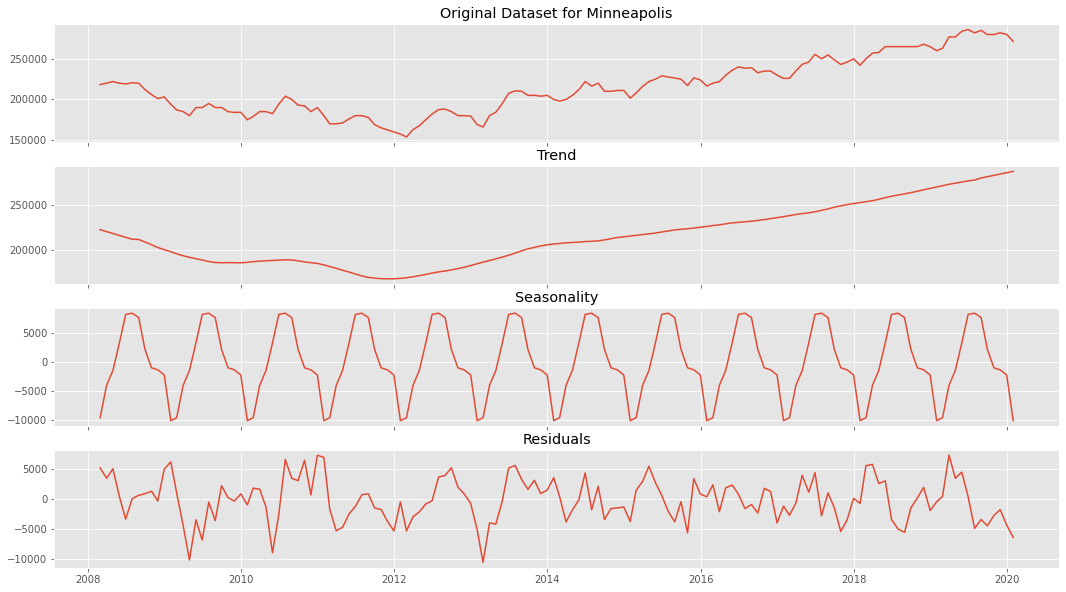

In [43]:
seasonal_decomposition(train.MSP, "Minneapolis")

### Miami

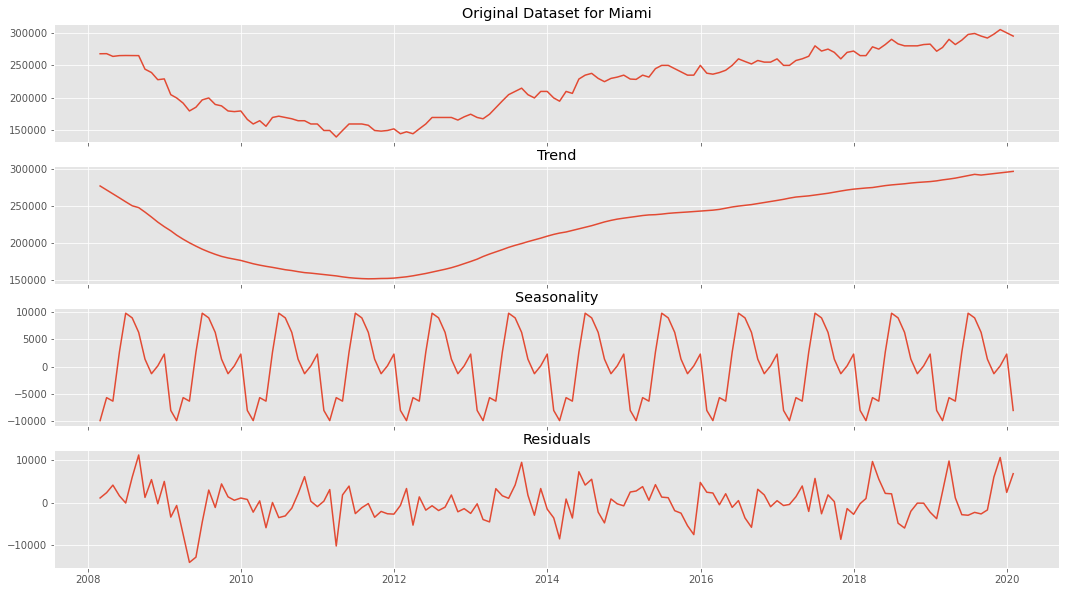

In [44]:
seasonal_decomposition(train.MIA, "Miami")

### Las Vegas

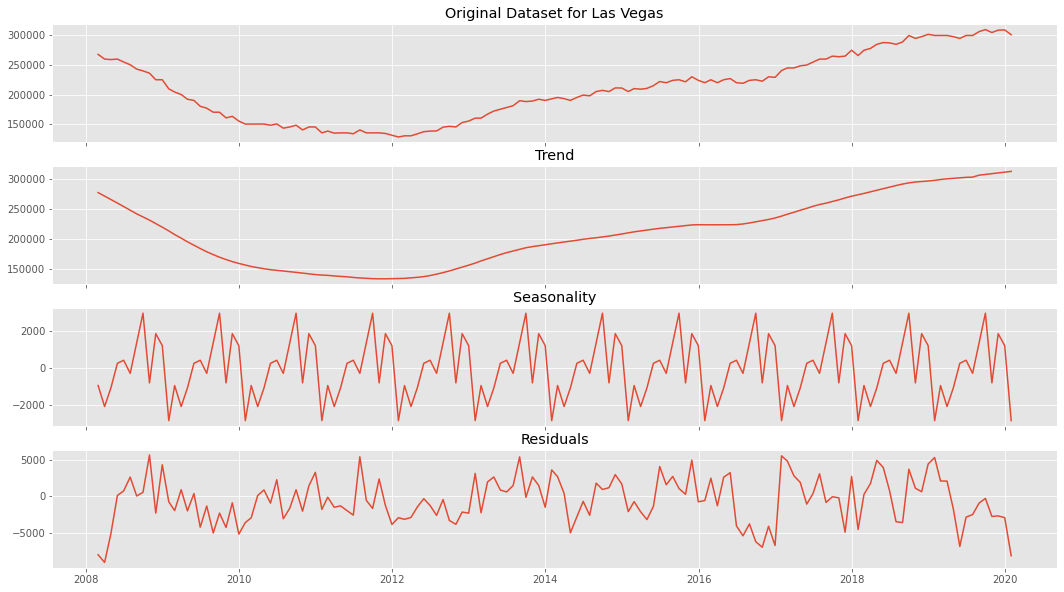

In [45]:
seasonal_decomposition(train.LAS, "Las Vegas")

## Checking for Stationarity

In [17]:
def checking_stationarity(Column):
    # Dickey Fuller Test on Original Dataset
    Dickey_Fuller = adfuller(Column)
    print("Augmented-Dickey-Fuller-Test: %f" % Dickey_Fuller[0])
    print("p-value: %f" % Dickey_Fuller[1])
    
    for key, element in Dickey_Fuller[4].items():
        print("\t%s: %.3f" % (key, element))
        
    if Dickey_Fuller[0] < Dickey_Fuller[4]["5%"]:
        print("Reject H0 - Time Series is Stationary")
    else:
        print("Failed to Reject H0 - Time Series is Non-Stationary")
    print( )
    # Dickey Fuller Test with a 6M lag
    Dickey_Fuller = adfuller(Column.diff().dropna())
    print("Augmented-Dickey-Fuller-Test on 1st Order Differencing: %f" % Dickey_Fuller[0])
    print("p-value: %f" % Dickey_Fuller[1])
    
    for key, element in Dickey_Fuller[4].items():
        print("\t%s: %.3f" % (key, element))
        
    if Dickey_Fuller[0] < Dickey_Fuller[4]["5%"]:
        print("Reject H0 - Time Series is Stationary")
    else:
        print("Failed to Reject H0 - Time Series is Non-Stationary")
    print( )
    # Dickey Fuller Test with a 12M lag
    Dickey_Fuller = adfuller(Column.diff().diff().dropna())
    print("Augmented-Dickey-Fuller-Test on 2nd Order Differencing: %f" % Dickey_Fuller[0])
    print("p-value: %f" % Dickey_Fuller[1])
    
    for key, element in Dickey_Fuller[4].items():
        print("\t%s: %.3f" % (key, element))
        
    if Dickey_Fuller[0] < Dickey_Fuller[4]["5%"]:
        print("Reject H0 - Time Series is Stationary")
    else:
        print("Failed to Reject H0 - Time Series is Non-Stationary")

In [18]:
def visualize_stationary(Column, City):
    
    # Plot Time Series
    fig, axes = plt.subplots(3, figsize=(18, 10),sharex=True)
    plt.style.use("ggplot")
    
    axes[0].plot(train.Date, Column)
    axes[0].set_title(str("Original Dataset for " + City))
    
    axes[1].plot(train.Date, Column.diff())
    axes[1].set_title("1st Order Differencing")
    
    axes[2].plot(train.Date, Column.diff().diff())
    axes[2].set_title("2nd Order Differencing")

### Minneapolis

In [19]:
checking_stationarity(train.MSP)

Augmented-Dickey-Fuller-Test: -0.387770
p-value: 0.912121
	1%: -3.482
	5%: -2.884
	10%: -2.579
Failed to Reject H0 - Time Series is Non-Stationary

Augmented-Dickey-Fuller-Test on 1st Order Differencing: -2.667323
p-value: 0.079865
	1%: -3.482
	5%: -2.884
	10%: -2.579
Failed to Reject H0 - Time Series is Non-Stationary

Augmented-Dickey-Fuller-Test on 2nd Order Differencing: -10.148634
p-value: 0.000000
	1%: -3.482
	5%: -2.884
	10%: -2.579
Reject H0 - Time Series is Stationary


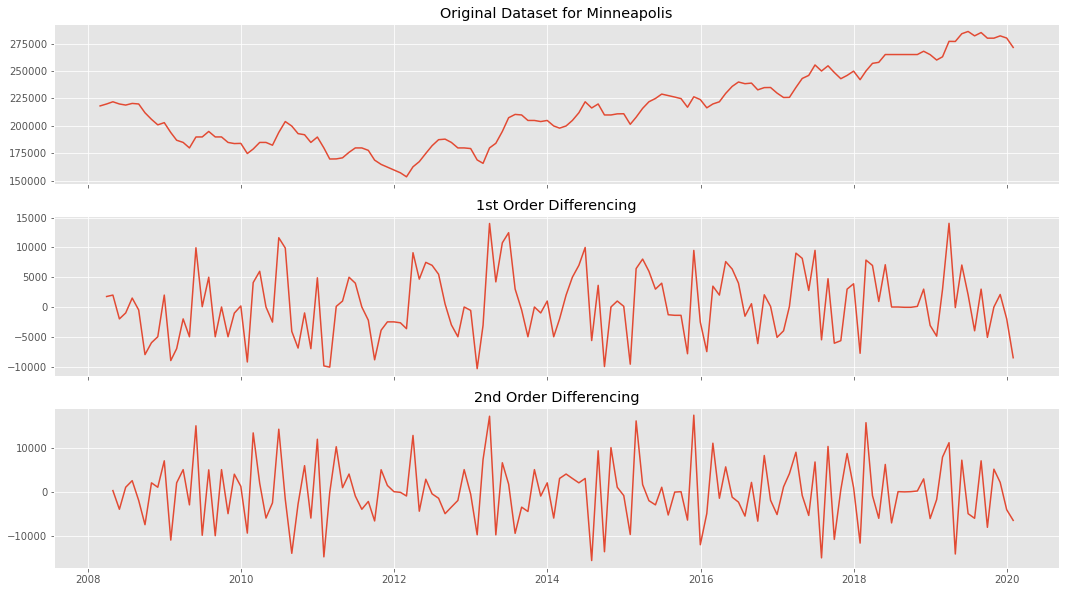

In [20]:
visualize_stationary(train.MSP, "Minneapolis")

### Miami

In [21]:
checking_stationarity(train.MIA)

Augmented-Dickey-Fuller-Test: -1.113736
p-value: 0.709563
	1%: -3.482
	5%: -2.884
	10%: -2.579
Failed to Reject H0 - Time Series is Non-Stationary

Augmented-Dickey-Fuller-Test on 1st Order Differencing: -4.395689
p-value: 0.000302
	1%: -3.482
	5%: -2.884
	10%: -2.579
Reject H0 - Time Series is Stationary

Augmented-Dickey-Fuller-Test on 2nd Order Differencing: -9.957397
p-value: 0.000000
	1%: -3.482
	5%: -2.884
	10%: -2.579
Reject H0 - Time Series is Stationary


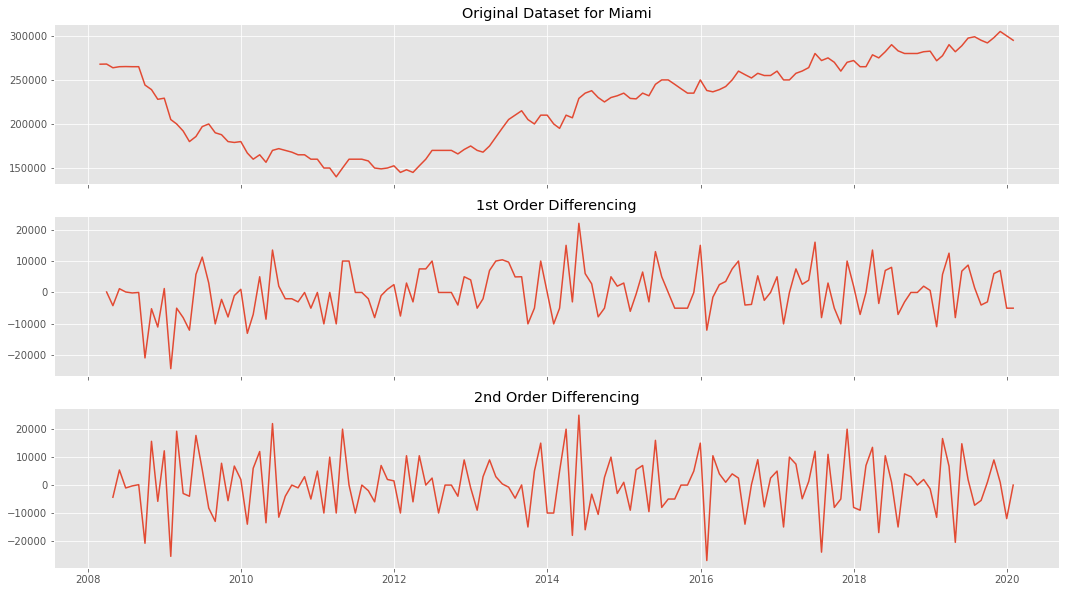

In [22]:
visualize_stationary(train.MIA, "Miami")

### Las Vegas

In [23]:
checking_stationarity(train.LAS)

Augmented-Dickey-Fuller-Test: -1.196836
p-value: 0.674955
	1%: -3.480
	5%: -2.883
	10%: -2.578
Failed to Reject H0 - Time Series is Non-Stationary

Augmented-Dickey-Fuller-Test on 1st Order Differencing: -2.364305
p-value: 0.152065
	1%: -3.480
	5%: -2.883
	10%: -2.578
Failed to Reject H0 - Time Series is Non-Stationary

Augmented-Dickey-Fuller-Test on 2nd Order Differencing: -6.006278
p-value: 0.000000
	1%: -3.480
	5%: -2.883
	10%: -2.578
Reject H0 - Time Series is Stationary


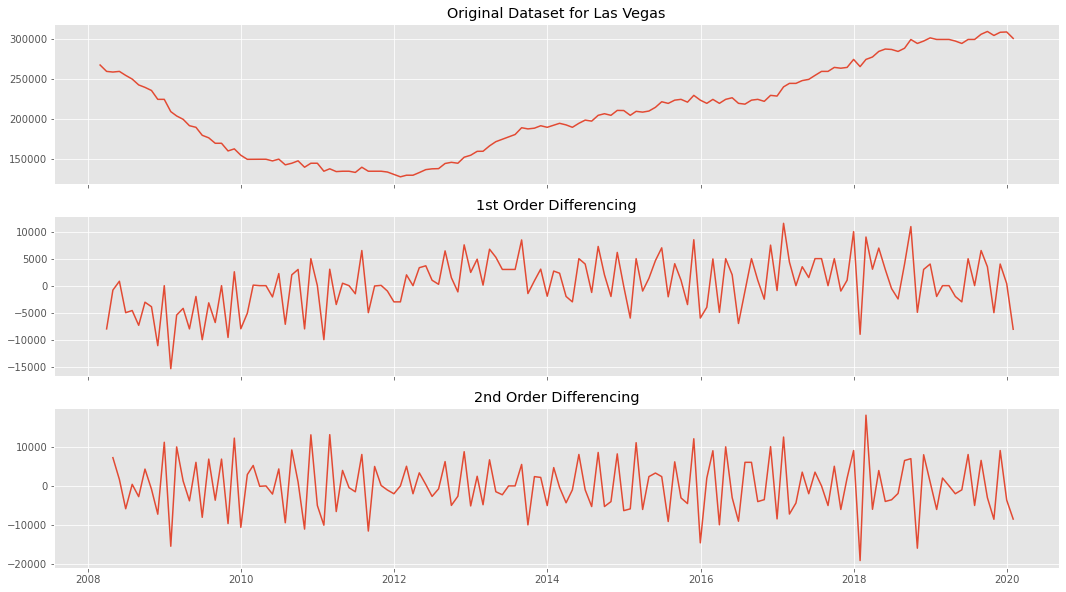

In [24]:
visualize_stationary(train.LAS, "Las Vegas")

## Checking for Autocorrelation and Partial Autocorrelation

In [25]:
def visualize_autocorrelation(Column):
    
    
    # Dickey Fuller Test on Original Dataset
    acf_values_1st = acf(Column.diff().dropna())
    print(np.round(acf_values_1st, 2))

    
    
    # Plot Autocorrelation while getting stationary data
    fig = plt.figure(figsize=(18, 10))
    plt.style.use("ggplot")
    
    ax1 = fig.add_subplot(311)
    fig = plot_acf(Column, ax = ax1, title = "Autocorrelation on Original Dataset")

    ax2 = fig.add_subplot(312)
    fig = plot_acf(Column.diff().dropna(), ax = ax2, title = "Autocorrelation on 1st Order Differencing")

    ax3 = fig.add_subplot(313)
    fig = plot_acf(Column.diff().diff().dropna(), ax = ax3, title = "Autocorrelation on 2nd Order Differencing")

In [26]:
def visualize_partial_autocorrelation(Column):
# Plot Partial Autocorrelation while getting stationary data   
    fig = plt.figure(figsize=(18, 10))
    plt.style.use("ggplot")
    
    ax4 = fig.add_subplot(311)
    fig = plot_pacf(Column, ax = ax4, title = "Partial Autocorrelation on Original Dataset")

    ax5 = fig.add_subplot(312)
    fig = plot_pacf(Column.diff().dropna(), ax = ax5, title = "Partial Autocorrelation on 1st Order Differencing")

    ax6 = fig.add_subplot(313)
    fig = plot_pacf(Column.diff().diff().dropna(), ax = ax6, title = "Partial Autocorrelation on 2nd Order Differencing")

### Minneapolis

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


[ 1.    0.18  0.07  0.02 -0.12 -0.18 -0.18 -0.25 -0.14  0.03  0.05  0.26
  0.48  0.24 -0.03  0.01 -0.18 -0.23 -0.22 -0.19 -0.15  0.03  0.02  0.33
  0.53  0.13 -0.07 -0.03 -0.15 -0.12 -0.17 -0.27 -0.02  0.02  0.11  0.25
  0.46  0.11 -0.09 -0.05 -0.12]


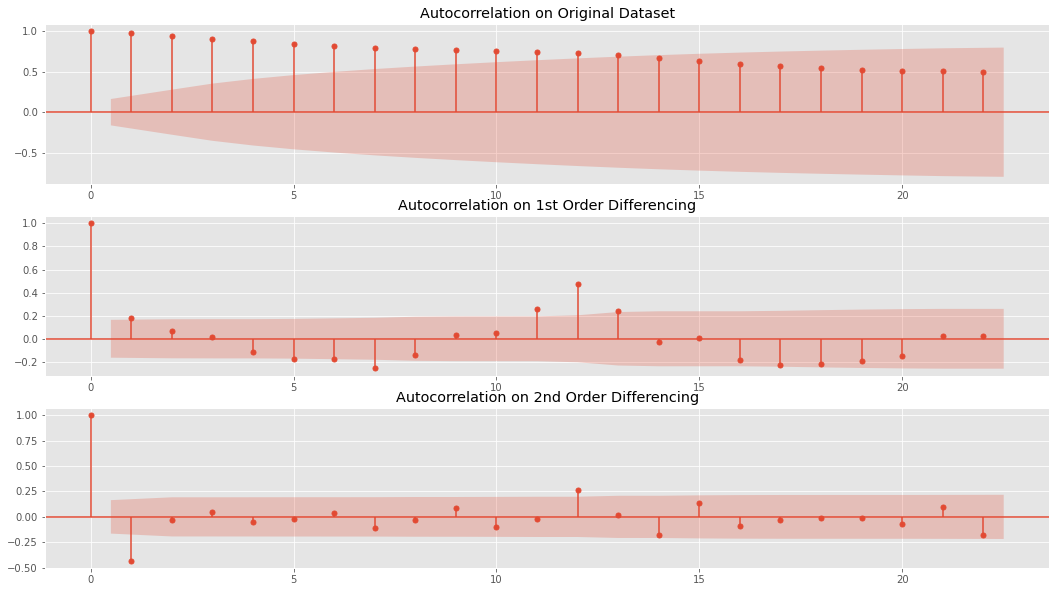

In [27]:
visualize_autocorrelation(train.MSP)

# ACF plot shows that 1st lag is significant (outside the blue band)
# the ACFs and PACF both decrease gradually. 
# We will need at least 1 differencing to make the series stationary. 
# When ACF and PACF plots do not have sharp cut offs and significant lags at higher orders, 
# its a indication of ARMA process with seasonality. --> SARIMA

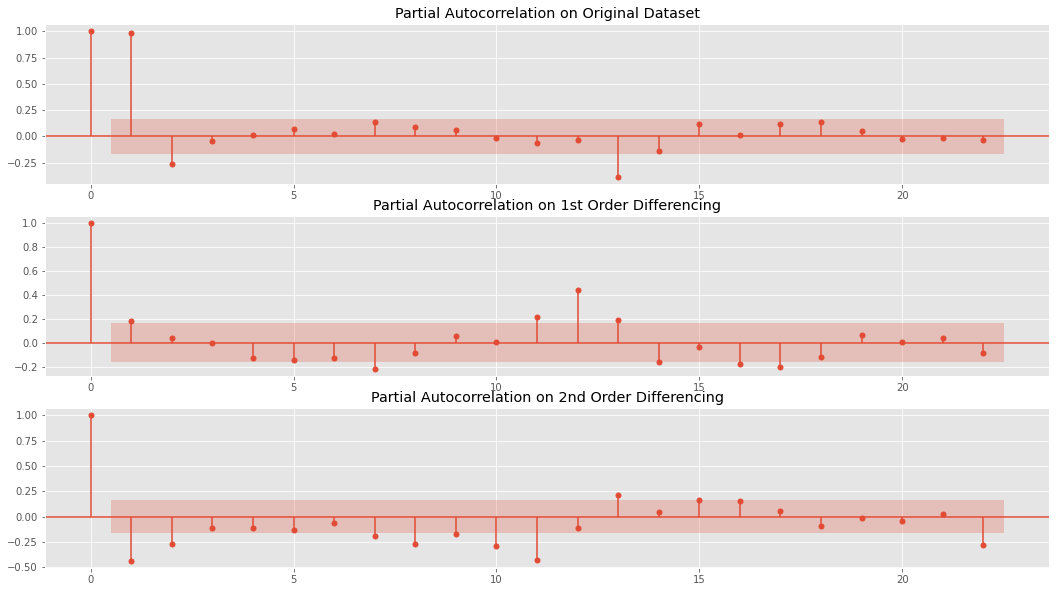

In [28]:
visualize_partial_autocorrelation(train.MSP)

### Miami

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


[ 1.    0.05  0.01  0.06 -0.05 -0.04  0.15  0.02 -0.19  0.1  -0.07  0.22
  0.52  0.06 -0.01  0.01 -0.13 -0.06  0.13 -0.01 -0.19  0.04 -0.07  0.25
  0.35  0.09 -0.1  -0.02 -0.14 -0.06  0.13 -0.1  -0.15 -0.02  0.01  0.14
  0.28  0.11 -0.16 -0.03 -0.21]


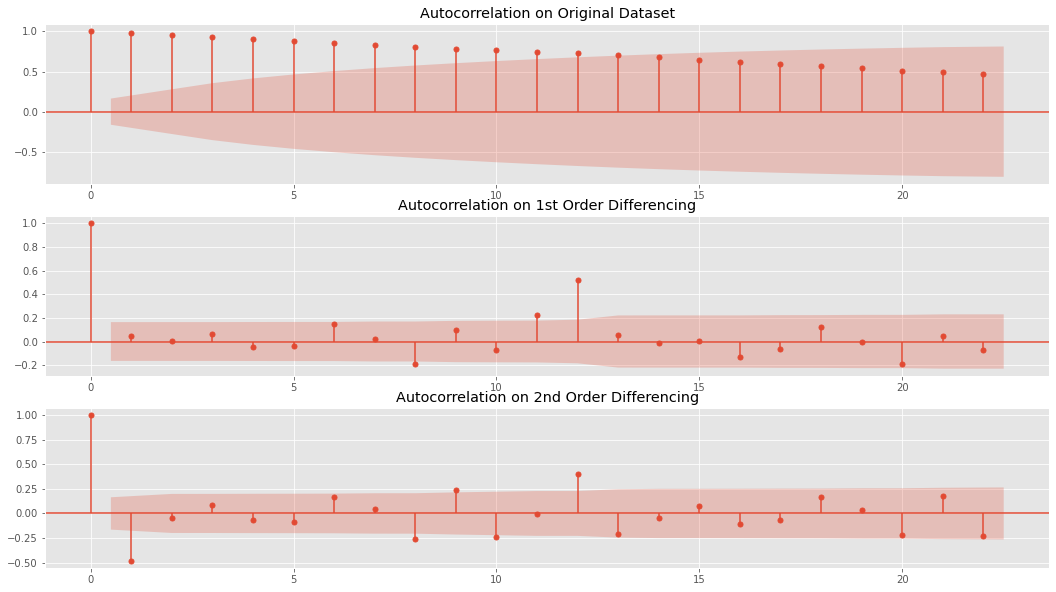

In [29]:
visualize_autocorrelation(train.MIA)

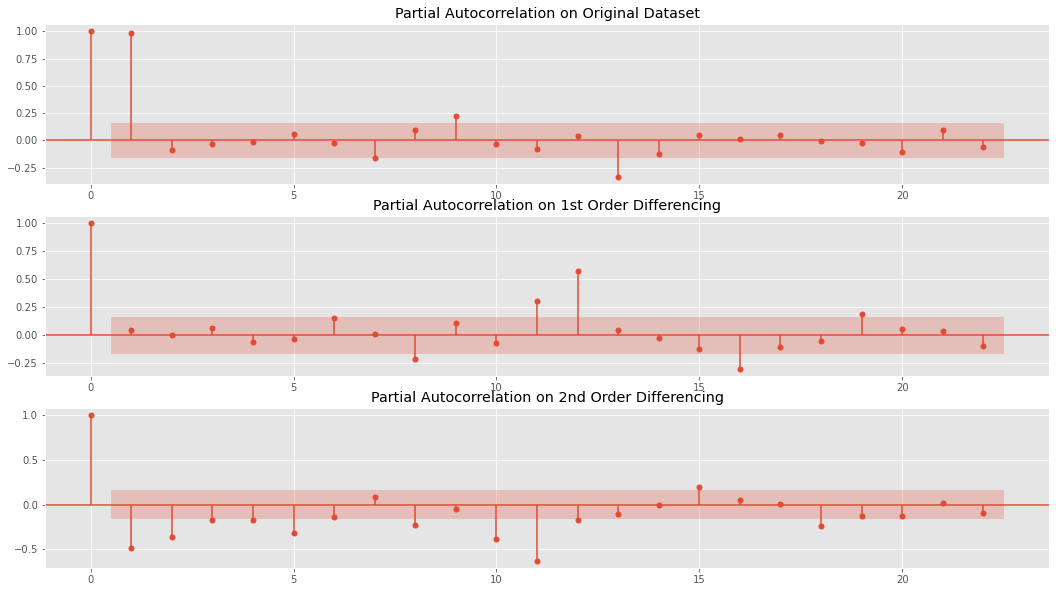

In [30]:
visualize_partial_autocorrelation(train.MIA)

### Las Vegas

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


[ 1.    0.01  0.26  0.46  0.1   0.32  0.27  0.2   0.12  0.36  0.16  0.16
  0.25  0.05  0.12  0.25  0.03  0.09  0.15  0.04  0.08  0.13  0.    0.01
  0.17  0.02  0.02  0.09  0.03  0.02  0.02  0.12 -0.08  0.02  0.09 -0.11
  0.07 -0.03 -0.08  0.01 -0.03]


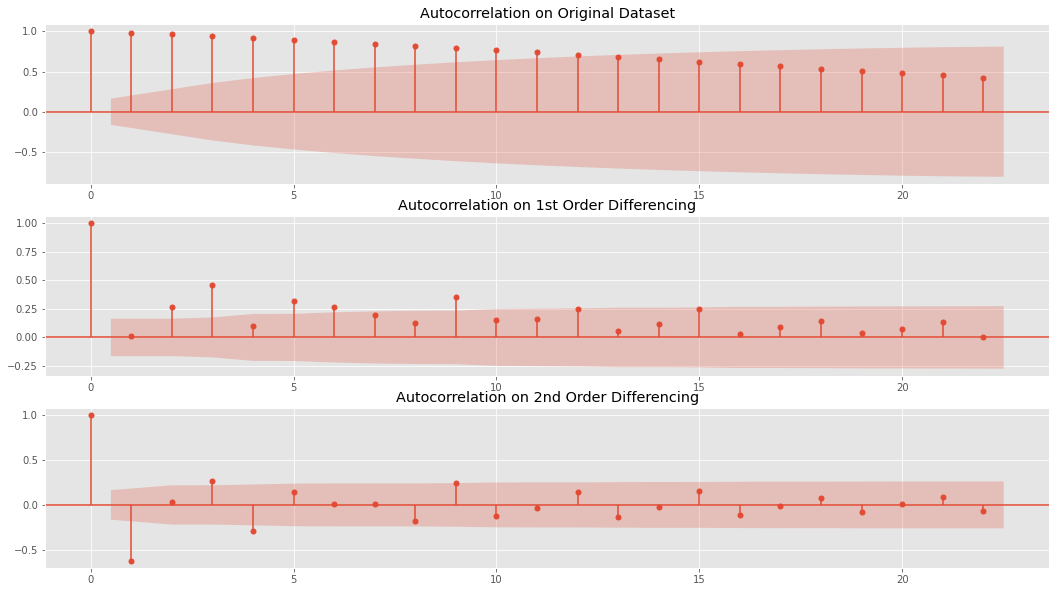

In [31]:
visualize_autocorrelation(train.LAS)

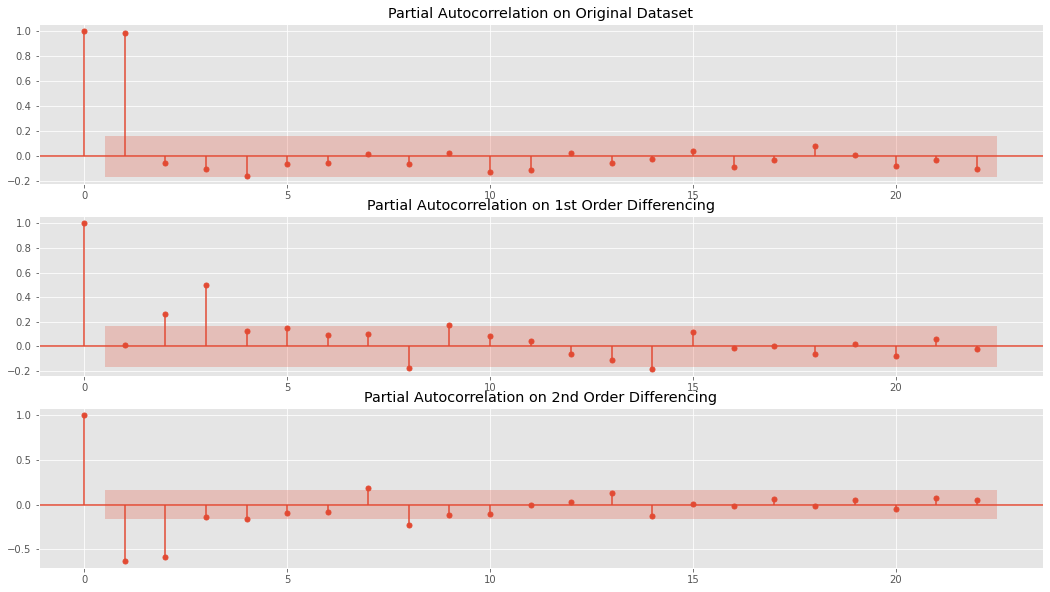

In [32]:
visualize_partial_autocorrelation(train.LAS)

## Safe data set for modeling

In [33]:
cities.to_csv('cities.csv')
train.to_csv('train.csv')
test.to_csv('test.csv')